# Canceling and Selecting Partials from Musical Tones Using Fractional-Delay Filters

Heidi-Maria Lehtonen, Vesa Välimäki and Timo I. Laakso

- Write a compact summary (approx. 2-3 pages) and your own thoughts
- Implement and explore some algorithm presented in the paper using Matlab
- Report your findings

The paper claims that one can use fractional-delay filters to cancel and select partials from musical signals. Such filters are variations of inverse transfer function of a comb filter. The idea of canceling harmonics from a musical signal using digital filters was first introduced by Moorer in 1974, where Moorer published papers about pitch detection and analyzing music data for additive synthesis. 

This paper is an extended study of Välimäki et al. which claimed that **the delay line in the inverse comb filter(ICF) can be replaced with a high-order fractional-delay filter** to obtain very accurate cancellation of neighboring harmonics to select a single harmonic or to extract the residual signal by canceling all harmonics.

Compared to general FFT-based techniques(McAulay and Quatieri 1986; Serra 1989; Serra and Smith 1990), which is a popular tool for signal decomposition, fractional-delay filters have smaller number of parameters, and one can design filter coefficients in closed form. The decomposition results in time-domain directly thus, no separate transformation is required.

There have been multiple efforts on analyzing the harmonic structure of musical signals; wavelets(Evangelista 1993) and high resolution tracking methods(Badeau, David, and Richard 2006). While these methods deliver very high frequency estimation accuracy, they are computationally expensive.  Fractional-delay filters estimate both frequency and amplitude with high accuracy, low cost and easy to use.





## Inverse Comb Filter(ICF)

The inverse comb filter(ICF) is an FIR filter in which input signal is delayed by $L$ samples and is then subtracted  from the original input signal.

$$
H_{\mathrm{ICF}}(z)=\left(1-\mathrm{z}^{-L}\right) / 2
$$

![icf_block_diagram](images/icf_block_diagram.png)

The magnitude response of this filter features periodic notches at the multiples of $f_{\mathrm{s}} / L$, where $f_{\mathrm{s}}$  is the sampling rate(Hz) and $L$ is the delay line length in samples.

## FIR Fractional-Delay Filter Design

For simplicity, we assume that the length of the delay element $L_1 = L_2 = 0$, no additional delay is present in either branch.

$$
H(z)=\frac{1}{2}\left[1-H_{\mathrm{fd}}(z)\right]
$$

![fd_filter_block_diagram](images/fd_filter_block_diagram.png)


where the $N$th-order transfer function $H_{\text{fd}}(z)$ can be expressed as 

$$
H_{\mathrm{fd}}(z)=\sum_{n=0}^{N} h(n) z^{-n}
$$

In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = 'Ubuntu'
# plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 18   # Time and Hz, i.e. labels
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 18  # Time(x) tick values
plt.rcParams['ytick.labelsize'] = 18  # Hz(y) tick values
plt.rcParams['legend.fontsize'] = 17
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.titlesize'] = 20   # Title font

from scipy.signal import freqz, lfilter

from asp import config
import numpy as np
from asp.core import read_wave, Wave
from IPython.display import Audio

In [2]:
from asp.core import thinkdsp, thinkplot

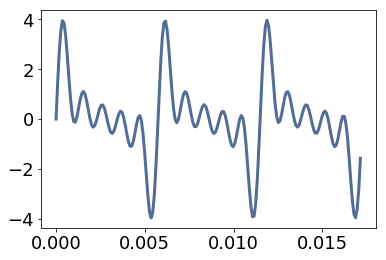

In [3]:
def get_tones(f0, num_tones=1):
    return thinkdsp.SumSignal(*tuple(thinkdsp.Sinusoid(freq=f0*order) for order in range(1,num_tones+1)))

s = get_tones(174, num_tones=5)

s.plot()

In [4]:
s.make_wave(framerate=44100).make_audio()

No handles with labels found to put in legend.


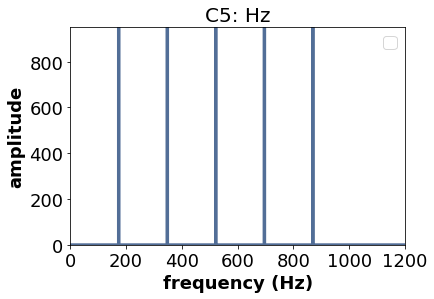

In [5]:
s.make_wave(framerate=44100).make_spectrum().plot()
thinkplot.config(xlabel='frequency (Hz)',
                 ylabel='amplitude',
                 xlim=[0, 1200],
                 ylim=[0, 950],
                 title = 'C5: Hz'
                )

Let's remove f2, i.d. 174.614 Hz using truncated Lagrange design method.

$$h_{\mathrm{TL}}(n)=\prod_{k=0 \atop k \neq n+K_{1}}^{M} \frac{D-k}{n+K_{1}-k} \quad \text{for $n = 0,1,2,\ldots,N$} $$

- $M$: prototype filter order ($M > N$)
- $K_1$: number of coefficients that are discarded from either end of the impulse response

In [13]:
np.floor(44100 /2/174.614 ) * 2

252.0

Text(0.5, 0, 'Frequency [Hz]')

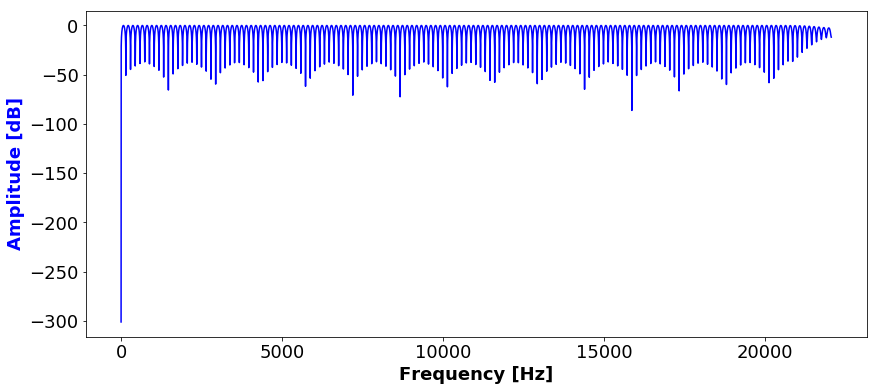

In [111]:
def lagrange_truncated(D, N=160, M=2*160, K1=20):
    """
    Args:
        D = 174.3     # Frequency to remove
        N = 160     # Chunk size
        M = 2*N     # Filter order
        d = 0.614   # Fractional delay parameter
        K1 = 20
        
        fs = 44100; 

        %calculate the fraction size for lagrange interpolation and filter order for inverse comb filter for selected fundamental
        fraction_size = (fs/2)/fundamenta_frequency - 1;
        filter_order = 2*floor(fraction_size);
    """
    h = np.ones(N+1)
    
    for n in range(N+1):                                               
        """Calculate largrange polynomial in vectorized form"""
        # Skip the k = n + K1 in order to avoid zero division error
        for k in range(N+1):
            if k == n:
                continue
            h[n] *= (D-k)/(n-k)
            
    return h


from scipy.signal import freqz, lfilter


nfft = 2**14
fs = 44100

#-------------------------------------------------
# Plot magnitude response
f0 = 146.832
D = fs / f0
N = int(2*D)
# N = 160
# print(N)
b = lagrange_truncated(D=D, N=N, M=7*N)
b1 = np.zeros_like(b)
#b1[0] = 1
#b = (b1-b ) / 2
#-------------------------------------------------
# w : ndarray
#     The frequencies at which `h` was computed, in the same units as `fs`.
#     By default, `w` is normalized to the range [0, pi) (radians/sample).
# h : ndarray
#     The frequency response, as complex numbers.
w, h = freqz(b=b, worN=nfft, whole=False)
h_dB = 20 * np.log10(abs(
    (1-h)/2    
#     h
))

# Renormalize `w` to Nyquist sample rate
w *= 0.5 * fs / np.pi

# plot amplitude in dB and frequency on log scale (essentially log-log)
# we were right, just looking at it wrong
plt.figure(figsize=(14,6))
plt.plot(w, h_dB, 'blue')
plt.ylabel('Amplitude [dB]', color='blue')
plt.xlabel('Frequency [Hz]')

Text(0.5, 0, 'Numerator coefficients')

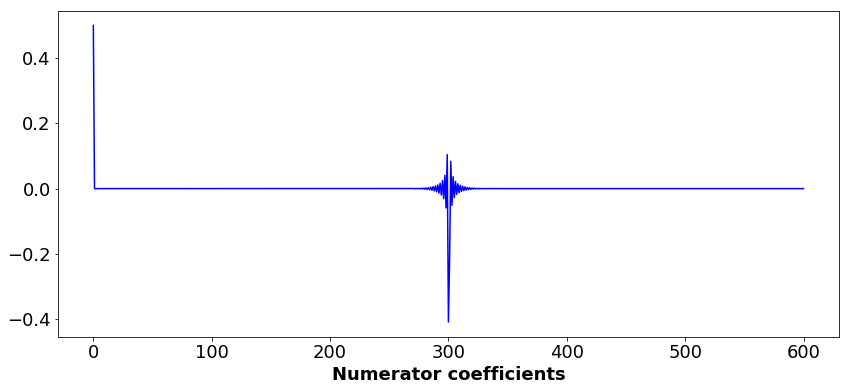

In [103]:
plt.figure(figsize=(14,6))
plt.plot(b, 'blue')
plt.xlabel('Numerator coefficients')

## Apply filter

In [97]:
# b = lagrange_truncated(D=174)
output = Wave(lfilter(b, [1], s.make_wave(framerate=44100).ys), np.arange(44100)/44100, framerate=44100)

In [99]:
from scipy.io import wavfile

In [100]:
_, clarinet = wavfile.read('data/d2.wav')

/Users/parks1/miniconda3/envs/asp/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [106]:
output = lfilter(b, [1], clarinet[:,0])

In [107]:
from IPython import display
from IPython.display import Audio

In [108]:
Audio(output, rate=44100)

No handles with labels found to put in legend.


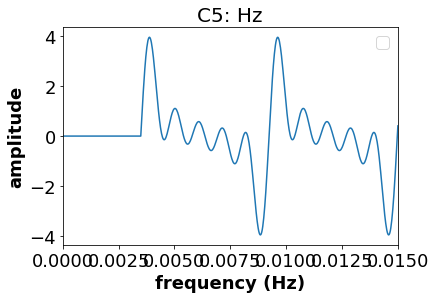

In [9]:
output.plot()
thinkplot.config(xlabel='frequency (Hz)',
                 ylabel='amplitude',
                 xlim=[0, 0.015],
                 title = 'C5: Hz'
                )

No handles with labels found to put in legend.


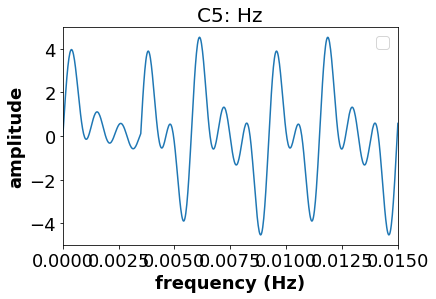

In [10]:
output.ys += s.make_wave(framerate=44100).ys
output.plot()
thinkplot.config(xlabel='frequency (Hz)',
                 ylabel='amplitude',
                 xlim=[0, 0.015],
                 title = 'C5: Hz'
                )

In [11]:
output.make_audio()

In [ ]:
s.make_wave(framerate=44100).make_spectrum().plot()
thinkplot.config(xlabel='frequency (Hz)',
                 ylabel='amplitude',
                 xlim=[0, 1200],
                 ylim=[0, 950],
                 title = 'C5: Hz'
                )

In [64]:
result.make_audio()

In [51]:
c2e2f2.make_audio()

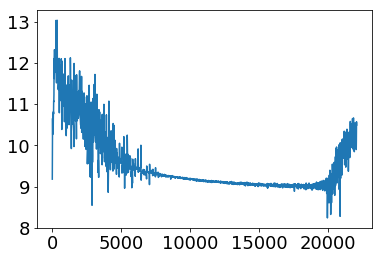

In [65]:
result.slice(44100,44100+4410).make_spectrum().plot()

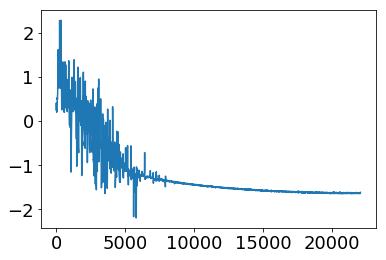

In [57]:
c2e2f2.slice(44100,44100+4410).make_spectrum().plot()

In [1]:
44100 / 4186

10.535117056856187